In [1719]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import boxcox
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
%matplotlib inline
sns.set_style("whitegrid")

In [1229]:
df_original = pd.read_csv('lung_dataframe_overall3.csv',converters={'Combined': lambda x: str(x),'State-county recode_x': lambda x: str(x)})

In [1230]:
df = df_original.copy()
df.index = df['State_and_county']
df['2014_pop'] = df['2014_y_x']
df = df.iloc[:,61:]

df.shape

(407, 76)

Set thresholds for county size per group

In [1231]:
large_counties = df[df['2014_pop']>500000]
medium_counties = df[(df['2014_pop']<=500000)&(df['2014_pop']>50000)]
small_counties = df[df['2014_pop']<50000]
print('Number of large counties:' + str(large_counties.shape))
print('Number of medium counties:' + str(medium_counties.shape))
print('Number of small counties:' + str(small_counties.shape))

Number of large counties:(26, 76)
Number of medium counties:(102, 76)
Number of small counties:(279, 76)


In [1232]:
# df = medium_counties
# df_original = medium_counties

Isolate age and gender standardized cancer rates

In [1453]:
cr = df.iloc[:,0:15]
cr['mean_cancer'] = cr.iloc[:,:14].mean(axis=1)
cr['mean_cancer_2004-2008'] = cr.iloc[:,4:9].mean(axis=1)
cr['mean_cancer_2009-2013'] = cr.iloc[:,9:14].mean(axis=1)
cancer_rates=cr.copy()
cancer_rates['State'] = df.State.values
cancer_rates['County'] = df.County.values
cancer_rates['State_and_county'] = df.State_and_county.values


In [1454]:
cancer_rates.head()

2000cancer_rate  2001cancer_rate  2002cancer_rate  \
State_and_county                                                          
Alameda County, CA          55.799261        48.316280        51.706237   
Amador County, CA           99.564760       112.054234        95.730423   
Butte County, CA            94.697434        94.086608        92.291507   
Calaveras County, CA       100.873416        84.737556        96.743747   
Colusa County, CA           21.257374        26.285354        15.599002   

                      2003cancer_rate  2004cancer_rate  2005cancer_rate  \
State_and_county                                                          
Alameda County, CA          51.988670        47.381203        48.905861   
Amador County, CA          108.125642        85.561497       115.667718   
Butte County, CA            83.222606        86.358623        77.764119   
Calaveras County, CA        77.705405        87.581406        77.271222   
Colusa County, CA           30.662306        44.539021        24.342746   

                      2006cancer_rate  2007cancer_rate  2008cancer_rate  \
State_and_county                                                          
Alameda County, CA          46.937176        48.429809        44.949662   
Amador County, CA           88.650171        77.407369        91.508053   
Butte County, CA            88.089879        75.413047        92.223125   
Calaveras County, CA       102.074058        88.614161        73.489679   
Colusa County, CA           14.360938        28.469751         9.463424   

                      2009cancer_rate          ...           2011cancer_rate  \
State_and_county                               ...                             
Alameda County, CA          51.316649          ...                 43.472046   
Amador County, CA           91.531984          ...                 93.273638   
Butte County, CA            79.626167          ...                 73.186143   
Calaveras County, CA       106.753813          ...                 84.245998   
Colusa County, CA           28.235294          ...                 18.721333   

                      2012cancer_rate  2013cancer_rate  2014cancer_rate  \
State_and_county                                                          
Alameda County, CA          42.750373        43.320816        41.644187   
Amador County, CA          105.152471       112.095363       133.373255   
Butte County, CA            83.642282        68.432711        66.525579   
Calaveras County, CA       107.238606        74.029208        89.708224   
Colusa County, CA           14.069315        18.759966        23.522770   

                      mean_cancer  mean_cancer_2004-2008  \
State_and_county                                           
Alameda County, CA      47.767503              47.320742   
Amador County, CA       99.087999              91.758962   
Butte County, CA        83.502888              83.969759   
Calaveras County, CA    88.767495              85.806105   
Colusa County, CA       22.386951              24.235176   

                      mean_cancer_2009-2013  State     County  \
State_and_county                                                
Alameda County, CA                44.866175     CA    Alameda   
Amador County, CA                102.592423     CA     Amador   
Butte County, CA                  76.978697     CA      Butte   
Calaveras County, CA              90.730855     CA  Calaveras   
Colusa County, CA                 19.687481     CA     Colusa   

                          State_and_county  
State_and_county                            
Alameda County, CA      Alameda County, CA  
Amador County, CA        Amador County, CA  
Butte County, CA          Butte County, CA  
Calaveras County, CA  Calaveras County, CA  
Colusa County, CA        Colusa County, CA  

[5 rows x 21 columns]

Text(0.5,0,'Mean County Lung Cancer Rates per 100,000, 2000-2014')

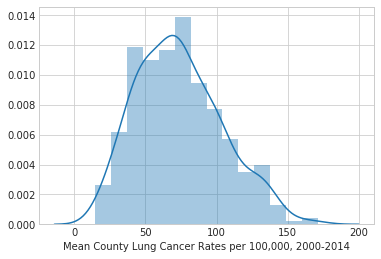

In [1455]:
sns.distplot(cancer_rates['mean_cancer'])
plt.xlabel('Mean County Lung Cancer Rates per 100,000, 2000-2014', fontsize=10)

Text(0,0.5,'Rates per 100,000')

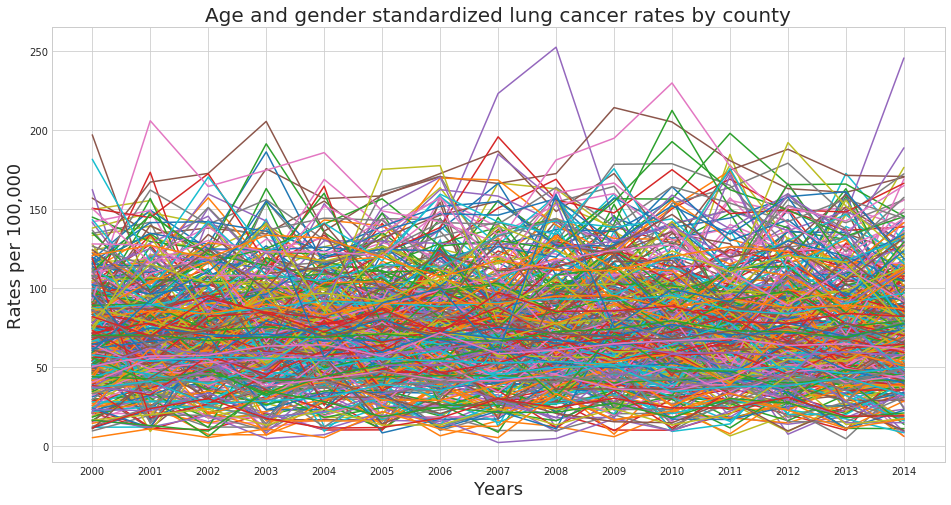

In [1456]:
fig = plt.subplots(figsize=(16,8))
for row in cancer_rates.iloc[:,0:15].values:
    plt.plot_date(x=[i for i in cancer_rates.iloc[:,0:15].columns.str[:4]], y=row, fmt="-")
 
plt.title('Age and gender standardized lung cancer rates by county', fontsize = 20)
plt.xlabel('Years', fontsize=18)
plt.ylabel('Rates per 100,000', fontsize=18)

In [1457]:
df_state = df_original.iloc[:,1:31]
df_state.index = df.State
df_state = pd.DataFrame(df_state.groupby(df_state.index)[df_state.columns].sum())
for i in range(2000, 2015):
    df_state[i] = (df_state[str(i)+"_x"]/df_state[str(i)+"_y_x"])*100000
    
df_state_rates = df_state.iloc[:,31:]
df_state_rates.head()

2001        2002        2003        2004        2005        2006  \
State                                                                           
CA      55.247025   54.302503   53.499233   53.083275   53.079141   52.908419   
GA      70.936128   70.934088   69.762615   68.422337   69.345392   69.307118   
IA      85.283439   86.802127   89.645228   87.377364   91.910788   90.726480   
KY     114.683877  115.719604  114.708203  116.329020  114.974133  117.999365   
MI      88.822716   87.443777   92.221901   88.099285   91.766470   91.833086   

             2007        2008        2009        2010        2011        2012  \
State                                                                           
CA      52.154405   51.301813   52.900212   50.334303   48.228593   48.393133   
GA      71.158051   70.970283   71.684187   67.887919   69.741569   73.130613   
IA      89.932430   90.470215   92.125690   88.895750   86.131619   86.002473   
KY     117.891593  120.619632  120.524734  122.493602  116.885849  118.333125   
MI      94.388533   96.273043   95.604249   95.141800   93.377117   90.336070   

             2013        2014  
State                          
CA      47.976329   47.771070  
GA      71.051135   71.079697  
IA      86.476045   86.955693  
KY     121.519138  119.520589  
MI      92.086280   94.195294

Text(0,0.5,'Rates per 100,000')

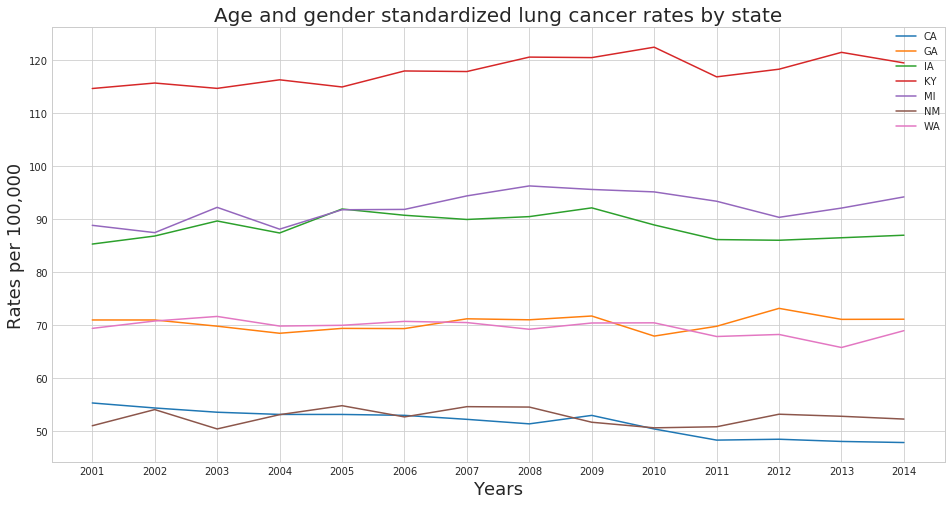

In [1458]:
fig = plt.subplots(figsize=(16,8))
for row in df_state_rates.values:
    plt.plot_date(x=[str(i) for i in df_state_rates.columns], y=row, fmt="-")
plt.legend(df_state_rates.index, loc=1, borderaxespad=0.)
plt.title('Age and gender standardized lung cancer rates by state', fontsize = 20)
plt.xlabel('Years', fontsize=18)
plt.ylabel('Rates per 100,000', fontsize=18)

Text(0.5,1,'Distribution of County Mean Lung Cancer Rates per 100,000 Grouped by State')

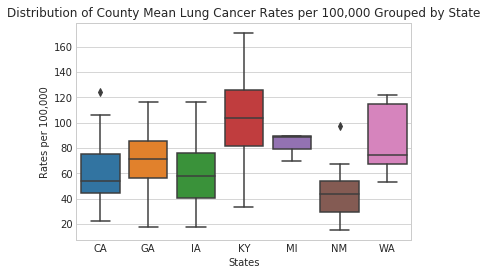

In [1459]:
sns.boxplot(x='State', y='mean_cancer', data=cancer_rates)
plt.xlabel('States', fontsize=10)
plt.ylabel('Rates per 100,000', fontsize=10)
plt.title('Distribution of County Mean Lung Cancer Rates per 100,000 Grouped by State')

In [1460]:
print ('Michigan counties: '+str(cancer_rates[cancer_rates['State']=='MI']['mean_cancer'].count()))
print ('California counties: '+str(cancer_rates[cancer_rates['State']=='CA']['mean_cancer'].count()))
print ('Kentucky counties: '+str(cancer_rates[cancer_rates['State']=='KY']['mean_cancer'].count()))
print ('Georgia counties: '+str(cancer_rates[cancer_rates['State']=='GA']['mean_cancer'].count()))
print ('New Mexico counties: '+str(cancer_rates[cancer_rates['State']=='NM']['mean_cancer'].count()))
print ('Iowa counties: '+str(cancer_rates[cancer_rates['State']=='IA']['mean_cancer'].count()))
print ('Washington counties: '+str(cancer_rates[cancer_rates['State']=='WA']['mean_cancer'].count()))

Michigan counties: 3
California counties: 55
Kentucky counties: 107
Georgia counties: 124
New Mexico counties: 23
Iowa counties: 83
Washington counties: 12


Isolate smoking data by county;
Weight mean smoking % by ratio of county population to state population in order to show aggregated results

In [1461]:
s = df.iloc[:,18:28]
s['mean_smoking'] = s.mean(axis=1)
s['mean_smoking_1996-2000'] = s.iloc[:,:5].mean(axis=1)
s['mean_smoking_2001-2005'] = s.iloc[:,5:10].mean(axis=1)
smoking = s.copy()
smoking['State'] = df.State.values
smoking['County'] = df.County.values
smoking['State_and_county'] = df.State_and_county.values
smoking['2014_pop'] = df['2014_pop']
smoking['State_pop'] = [smoking[smoking['State']==i]['2014_pop'].sum() for i in smoking.State.values]
smoking['Weighted Mean'] = smoking['mean_smoking'].values*(smoking['2014_pop'].values.astype(float)/smoking['State_pop'].values.astype(float))

smoking.head()

1996smoking_total  1997smoking_total  1998smoking_total  \
State_and_county                                                                
Alameda County, CA                 20.2               20.0               19.8   
Amador County, CA                  23.8               23.7               23.6   
Butte County, CA                   24.0               23.9               23.8   
Calaveras County, CA               23.3               23.2               23.2   
Colusa County, CA                  25.6               25.5               25.4   

                      1999smoking_total  2000smoking_total  2001smoking_total  \
State_and_county                                                                
Alameda County, CA                 19.6               19.3               18.7   
Amador County, CA                  23.3               23.0               23.3   
Butte County, CA                   23.4               23.3               23.0   
Calaveras County, CA               22.8               22.3               22.6   
Colusa County, CA                  24.9               24.3               24.2   

                      2002smoking_total  2003smoking_total  2004smoking_total  \
State_and_county                                                                
Alameda County, CA                 17.9               17.9               17.1   
Amador County, CA                  23.2               24.0               24.4   
Butte County, CA                   23.5               23.2               22.7   
Calaveras County, CA               21.9               22.6               22.8   
Colusa County, CA                  25.4               24.3               24.1   

                      2005smoking_total  mean_smoking  mean_smoking_1996-2000  \
State_and_county                                                                
Alameda County, CA                 16.0         18.65                   19.78   
Amador County, CA                  24.3         23.66                   23.48   
Butte County, CA                   22.3         23.31                   23.68   
Calaveras County, CA               22.9         22.76                   22.96   
Colusa County, CA                  23.7         24.74                   25.14   

                      mean_smoking_2001-2005 State     County  \
State_and_county                                                
Alameda County, CA                     17.52    CA    Alameda   
Amador County, CA                      23.84    CA     Amador   
Butte County, CA                       22.94    CA      Butte   
Calaveras County, CA                   22.56    CA  Calaveras   
Colusa County, CA                      24.34    CA     Colusa   

                          State_and_county   2014_pop   State_pop  \
State_and_county                                                    
Alameda County, CA      Alameda County, CA  1478621.0  35272394.0   
Amador County, CA        Amador County, CA    30819.0  35272394.0   
Butte County, CA          Butte County, CA   198402.0  35272394.0   
Calaveras County, CA  Calaveras County, CA    37418.0  35272394.0   
Colusa County, CA        Colusa County, CA     6599.0  35272394.0   

                      Weighted Mean  
State_and_county                     
Alameda County, CA         0.781809  
Amador County, CA          0.020673  
Butte County, CA           0.131115  
Calaveras County, CA       0.024144  
Colusa County, CA          0.004629

In [1462]:
smoking.groupby('State')['Weighted Mean'].sum()

State
CA    19.581845
GA    24.454523
IA    24.974355
KY    30.976641
MI    27.124149
NM    24.971750
WA    22.032957
Name: Weighted Mean, dtype: float64

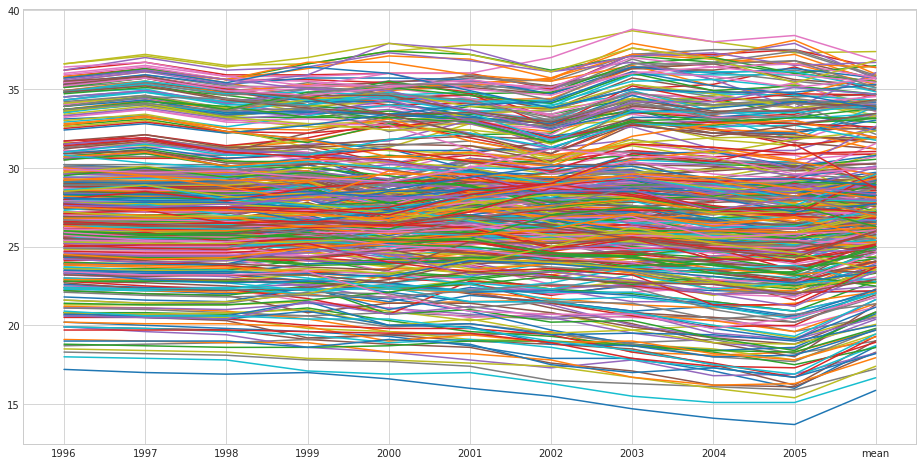

In [1463]:
fig = plt.subplots(figsize=(16,8))
for row in smoking.iloc[:,:11].values:
    plt.plot_date(x=[i for i in smoking.iloc[:,:11].columns.str[:4]], y=row, fmt="-")

Text(0.5,1,'Daily/Nondaily Smokers,  Grouped by State')

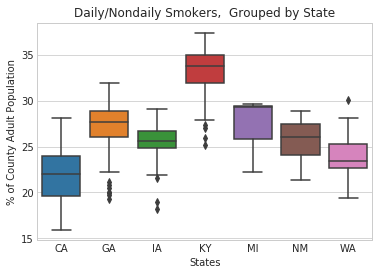

In [1464]:
sns.boxplot(x='State', y='mean_smoking', data=smoking)
plt.xlabel('States', fontsize=10)
plt.ylabel('% of County Adult Population', fontsize=10)
plt.title('Daily/Nondaily Smokers,  Grouped by State')

In [1465]:
sd = df.iloc[:,35:45]
sd['mean_smoking_daily'] = sd.mean(axis=1)
sd['mean_smoking_daily_1996-2000'] = sd.iloc[:,:5].mean(axis=1)
sd['mean_smoking_daily_2001-2005'] = sd.iloc[:,5:10].mean(axis=1)
smoking_daily = sd.copy()
smoking_daily['State'] = df.State.values
smoking_daily['County'] = df.County.values
smoking_daily['State_and_county'] = df.State_and_county.values
smoking_daily['2014_pop'] = df['2014_pop']
smoking_daily['State_pop'] = [smoking_daily[smoking_daily['State']==i]['2014_pop'].sum() for i in smoking_daily.State.values]
smoking_daily['Weighted Mean'] = smoking_daily['mean_smoking_daily'].values*(smoking_daily['2014_pop'].values.astype(float)/smoking_daily['State_pop'].values.astype(float))

smoking_daily.head()


1996smoking_daily  1997smoking_daily  1998smoking_daily  \
State_and_county                                                                
Alameda County, CA                 14.3               14.0               13.6   
Amador County, CA                  19.2               18.9               18.7   
Butte County, CA                   19.3               19.0               18.7   
Calaveras County, CA               19.0               18.7               18.4   
Colusa County, CA                  19.2               18.8               18.4   

                      1999smoking_daily  2000smoking_daily  2001smoking_daily  \
State_and_county                                                                
Alameda County, CA                 13.4               13.6               13.2   
Amador County, CA                  18.3               18.0               17.7   
Butte County, CA                   18.3               18.2               18.1   
Calaveras County, CA               17.9               17.2               17.3   
Colusa County, CA                  18.2               17.9               18.0   

                      2002smoking_daily  2003smoking_daily  2004smoking_daily  \
State_and_county                                                                
Alameda County, CA                 12.6               12.6               12.1   
Amador County, CA                  17.6               17.9               18.2   
Butte County, CA                   18.1               18.0               17.4   
Calaveras County, CA               16.8               17.0               17.0   
Colusa County, CA                  17.8               17.2               16.7   

                      2005smoking_daily  mean_smoking_daily  \
State_and_county                                              
Alameda County, CA                 11.0               13.04   
Amador County, CA                  18.1               18.26   
Butte County, CA                   16.9               18.20   
Calaveras County, CA               17.0               17.63   
Colusa County, CA                  16.2               17.84   

                      mean_smoking_daily_1996-2000  \
State_and_county                                     
Alameda County, CA                           13.78   
Amador County, CA                            18.62   
Butte County, CA                             18.70   
Calaveras County, CA                         18.24   
Colusa County, CA                            18.50   

                      mean_smoking_daily_2001-2005 State     County  \
State_and_county                                                      
Alameda County, CA                           12.30    CA    Alameda   
Amador County, CA                            17.90    CA     Amador   
Butte County, CA                             17.70    CA      Butte   
Calaveras County, CA                         17.02    CA  Calaveras   
Colusa County, CA                            17.18    CA     Colusa   

                          State_and_county   2014_pop   State_pop  \
State_and_county                                                    
Alameda County, CA      Alameda County, CA  1478621.0  35272394.0   
Amador County, CA        Amador County, CA    30819.0  35272394.0   
Butte County, CA          Butte County, CA   198402.0  35272394.0   
Calaveras County, CA  Calaveras County, CA    37418.0  35272394.0   
Colusa County, CA        Colusa County, CA     6599.0  35272394.0   

                      Weighted Mean  
State_and_county                     
Alameda County, CA         0.546638  
Amador County, CA          0.015955  
Butte County, CA           0.102372  
Calaveras County, CA       0.018702  
Colusa County, CA          0.003338

Text(0.5,1,'Daily Smokers,  Grouped by State')

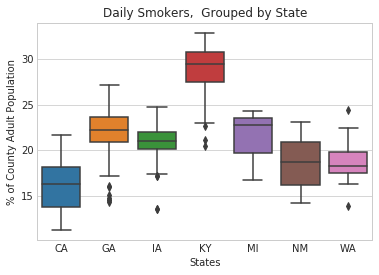

In [1466]:
sns.boxplot(x='State', y='mean_smoking_daily', data=smoking_daily)
plt.xlabel('States', fontsize=10)
plt.ylabel('% of County Adult Population', fontsize=10)
plt.title('Daily Smokers,  Grouped by State')

In [1721]:
pm = df.iloc[:,52:62]
pm['mean_pm25'] = pm.iloc[:,0:].mean(axis=1)
pm['mean_pm25_2001-2005'] = pm.iloc[:,:5].mean(axis=1)
pm['mean_pm25_2006-2010'] = pm.iloc[:,5:10].mean(axis=1)
pm_25 = pm.copy()
pm_25['State'] = df.State.values
pm_25['County'] = df.County.values
pm_25['State_and_county'] = df.State_and_county.values

pm_25.head()


2001PM2.5  2002PM2.5  2003PM2.5  2004PM2.5  2005PM2.5  \
State_and_county                                                              
Alameda County, CA    13.007198  14.190016  12.459122  11.617424  11.197772   
Amador County, CA     11.560446  13.538512  12.301152  11.760466  11.287103   
Butte County, CA      11.318704  12.909217  11.744747  11.366081  10.858977   
Calaveras County, CA  11.358021  13.280062  12.339021  11.399416  10.832450   
Colusa County, CA     10.387352  11.927744  10.772772   9.612164   9.264893   

                      2006PM2.5  2007PM2.5  2008PM2.5  2009PM2.5  2010PM2.5  \
State_and_county                                                              
Alameda County, CA    11.763339  11.182633  13.056139  10.936849   9.255255   
Amador County, CA     11.823173  10.740916  12.299932   9.686501   7.934685   
Butte County, CA      11.083041  10.470951  14.972811   9.251522   7.670181   
Calaveras County, CA  11.380721  10.407938  11.818147   9.392393   7.964309   
Colusa County, CA     10.160168   8.243028  11.858425   7.971614   6.340477   

                      mean_pm25  mean_pm25_2001-2005  mean_pm25_2006-2010  \
State_and_county                                                            
Alameda County, CA    11.866575            12.494306            11.238843   
Amador County, CA     11.293289            12.089536            10.497042   
Butte County, CA      11.164623            11.639545            10.689701   
Calaveras County, CA  11.017248            11.841794            10.192702   
Colusa County, CA      9.653864            10.392985             8.914742   

                     State     County      State_and_county  
State_and_county                                             
Alameda County, CA      CA    Alameda    Alameda County, CA  
Amador County, CA       CA     Amador     Amador County, CA  
Butte County, CA        CA      Butte      Butte County, CA  
Calaveras County, CA    CA  Calaveras  Calaveras County, CA  
Colusa County, CA       CA     Colusa     Colusa County, CA

Text(0.5,1,'Annual average ambient concentrations of PM 2.5 in micrograms per cubic meter')

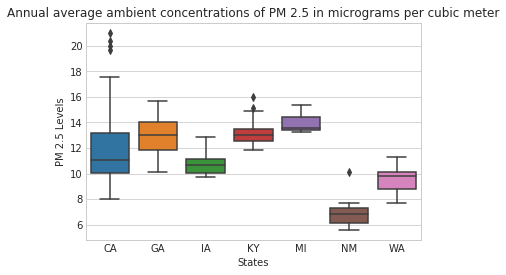

In [1468]:
sns.boxplot(x='State', y='mean_pm25', data=pm_25)
plt.xlabel('States', fontsize=10)
plt.ylabel('PM 2.5 Levels', fontsize=10)
plt.title('Annual average ambient concentrations of PM 2.5 in micrograms per cubic meter')

In [1469]:
oz = df.iloc[:,63:73]
oz['mean_ozone'] = oz.mean(axis=1)
oz['mean_ozone_2001-2005'] = oz.iloc[:,:5].mean(axis=1)
oz['mean_ozone_2006-2010'] = oz.iloc[:,5:10].mean(axis=1)
ozone = oz.copy()
ozone['State'] = df.State.values
ozone['County'] = df.County.values
ozone['State_and_county'] = df.State_and_county.values

ozone.head()

2001Ozone  2002Ozone  2003Ozone  2004Ozone  2005Ozone  \
State_and_county                                                              
Alameda County, CA          7.0       10.0        6.0        4.0        2.0   
Amador County, CA          17.0       21.0       21.0        7.0       13.0   
Butte County, CA           24.0       43.0       22.0       14.0       15.0   
Calaveras County, CA       21.0       41.0       42.0       12.0       25.0   
Colusa County, CA          12.0        4.0        0.0        0.0        0.0   

                      2006Ozone  2007Ozone  2008Ozone  2009Ozone  2010Ozone  \
State_and_county                                                              
Alameda County, CA         10.0        2.0        6.0        6.0        4.0   
Amador County, CA          18.0        1.0       31.0        1.0        4.0   
Butte County, CA           33.0       12.0       17.0       13.0        4.0   
Calaveras County, CA       35.0        6.0       19.0        9.0        7.0   
Colusa County, CA           1.0        0.0        1.0        0.0        1.0   

                      mean_ozone  mean_ozone_2001-2005  mean_ozone_2006-2010  \
State_and_county                                                               
Alameda County, CA           5.7                   5.8                   5.6   
Amador County, CA           13.4                  15.8                  11.0   
Butte County, CA            19.7                  23.6                  15.8   
Calaveras County, CA        21.7                  28.2                  15.2   
Colusa County, CA            1.9                   3.2                   0.6   

                     State     County      State_and_county  
State_and_county                                             
Alameda County, CA      CA    Alameda    Alameda County, CA  
Amador County, CA       CA     Amador     Amador County, CA  
Butte County, CA        CA      Butte      Butte County, CA  
Calaveras County, CA    CA  Calaveras  Calaveras County, CA  
Colusa County, CA       CA     Colusa     Colusa County, CA

Text(0.5,1,'Number of days with maximum 8-hour average ozone concentration over the National Ambient Air Quality Standard')

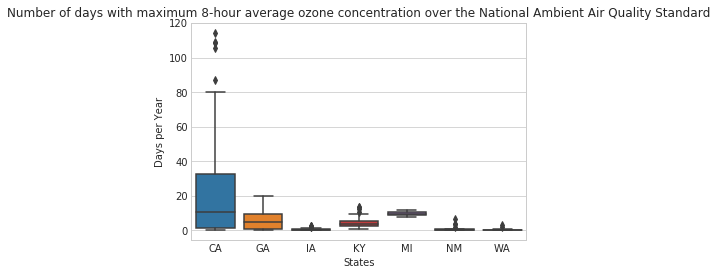

In [1470]:
sns.boxplot(x='State', y='mean_ozone', data=ozone)
plt.xlabel('States', fontsize=10)
plt.ylabel('Days per Year', fontsize=10)
plt.title('Number of days with maximum 8-hour average ozone concentration over the National Ambient Air Quality Standard')

Text(0.5,0,'Days of Harmful Levels of Ozone')

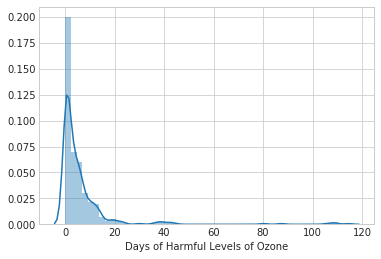

In [1471]:
sns.distplot(oz.mean_ozone)
plt.xlabel('Days of Harmful Levels of Ozone', fontsize=10)

Text(0.5,0,'Log - Days of Harmful Levels of Ozone')

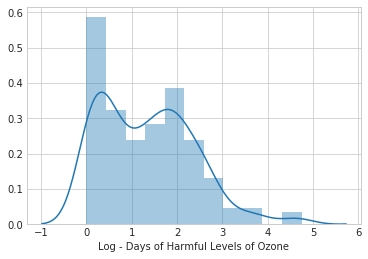

In [1472]:
oz['log_ozone'] = oz[['mean_ozone']].applymap(lambda x: np.log(x+1))
sns.distplot(oz['log_ozone'])
plt.xlabel('Log - Days of Harmful Levels of Ozone', fontsize=10)

Text(0.5,0,'Mean Radon Levels (pCi/L)')

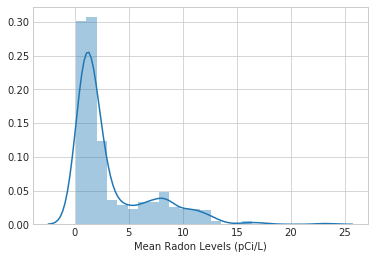

In [1473]:
sns.distplot(df.radon_mean)
plt.xlabel('Mean Radon Levels (pCi/L)', fontsize=10)

Log transform radon data

In [1474]:
df['log_radon'] = df[['radon_mean']].applymap(lambda x: np.log(x+1))

Text(0.5,0,'Mean Radon Levels (pCi/L)')

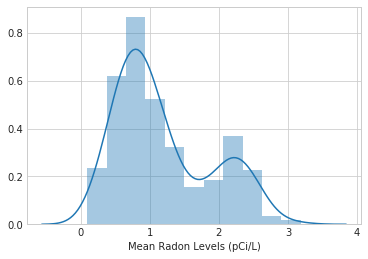

In [1475]:
sns.distplot(df['log_radon'])
plt.xlabel('Mean Radon Levels (pCi/L)', fontsize=10)

In [1681]:
data = df.copy()
data = data[['log_radon', 'radon_mean']]
data['cancer_mean'] = cancer_rates['mean_cancer']
data['mean_cancer_2004-2008'] = cr['mean_cancer_2004-2008']
data['mean_cancer_2009-2013']  = cr['mean_cancer_2009-2013']
data['mean_smoking_total'] = smoking['mean_smoking']
data['mean_smoking_1996-2000'] = s['mean_smoking_1996-2000']
data['mean_smoking_2001-2005'] = s['mean_smoking_2001-2005']
data['mean_smoking_daily'] = smoking_daily['mean_smoking_daily']
data['mean_smoking_daily_1996-2000'] = sd['mean_smoking_daily_1996-2000']
data['mean_smoking_daily_2001-2005'] = sd['mean_smoking_daily_2001-2005']
data['pm_25'] = pm_25['mean_pm25']
data['mean_pm25_2001-2005'] = pm['mean_pm25_2001-2005']
data['mean_pm25_2006-2010'] = pm['mean_pm25_2006-2010']
data['ozone'] = ozone['mean_ozone']
data['mean_ozone_2001-2005'] = oz['mean_ozone_2001-2005']
data['mean_ozone_2006-2010'] = oz['mean_ozone_2006-2010']
data['2014cancer_rate'] = cancer_rates['2014cancer_rate']
data['log_ozone'] = oz.log_ozone
data.head()

log_radon  radon_mean  cancer_mean  \
State_and_county                                           
Alameda County, CA     0.586860    0.798333    47.767503   
Amador County, CA      0.891998    1.440000    99.087999   
Butte County, CA       0.396333    0.486364    83.502888   
Calaveras County, CA   0.783394    1.188889    88.767495   
Colusa County, CA      0.438255    0.550000    22.386951   

                      mean_cancer_2004-2008  mean_cancer_2009-2013  \
State_and_county                                                     
Alameda County, CA                47.320742              44.866175   
Amador County, CA                 91.758962             102.592423   
Butte County, CA                  83.969759              76.978697   
Calaveras County, CA              85.806105              90.730855   
Colusa County, CA                 24.235176              19.687481   

                      mean_smoking_total  mean_smoking_1996-2000  \
State_and_county                                                   
Alameda County, CA                 18.65                   19.78   
Amador County, CA                  23.66                   23.48   
Butte County, CA                   23.31                   23.68   
Calaveras County, CA               22.76                   22.96   
Colusa County, CA                  24.74                   25.14   

                      mean_smoking_2001-2005  mean_smoking_daily  \
State_and_county                                                   
Alameda County, CA                     17.52               13.04   
Amador County, CA                      23.84               18.26   
Butte County, CA                       22.94               18.20   
Calaveras County, CA                   22.56               17.63   
Colusa County, CA                      24.34               17.84   

                      mean_smoking_daily_1996-2000  \
State_and_county                                     
Alameda County, CA                           13.78   
Amador County, CA                            18.62   
Butte County, CA                             18.70   
Calaveras County, CA                         18.24   
Colusa County, CA                            18.50   

                      mean_smoking_daily_2001-2005      pm_25  \
State_and_county                                                
Alameda County, CA                           12.30  11.866575   
Amador County, CA                            17.90  11.293289   
Butte County, CA                             17.70  11.164623   
Calaveras County, CA                         17.02  11.017248   
Colusa County, CA                            17.18   9.653864   

                      mean_pm25_2001-2005  mean_pm25_2006-2010  ozone  \
State_and_county                                                        
Alameda County, CA              12.494306            11.238843    5.7   
Amador County, CA               12.089536            10.497042   13.4   
Butte County, CA                11.639545            10.689701   19.7   
Calaveras County, CA            11.841794            10.192702   21.7   
Colusa County, CA               10.392985             8.914742    1.9   

                      mean_ozone_2001-2005  mean_ozone_2006-2010  \
State_and_county                                                   
Alameda County, CA                     5.8                   5.6   
Amador County, CA                     15.8                  11.0   
Butte County, CA                      23.6                  15.8   
Calaveras County, CA                  28.2                  15.2   
Colusa County, CA                      3.2                   0.6   

                      2014cancer_rate  log_ozone  
State_and_county                                  
Alameda County, CA          41.644187   1.902108  
Amador County, CA          133.373255   2.667228  
Butte County, CA            66.525579   3.030134  
Calaveras County, CA        89.708224   3.122365  
Colusa County, CA         

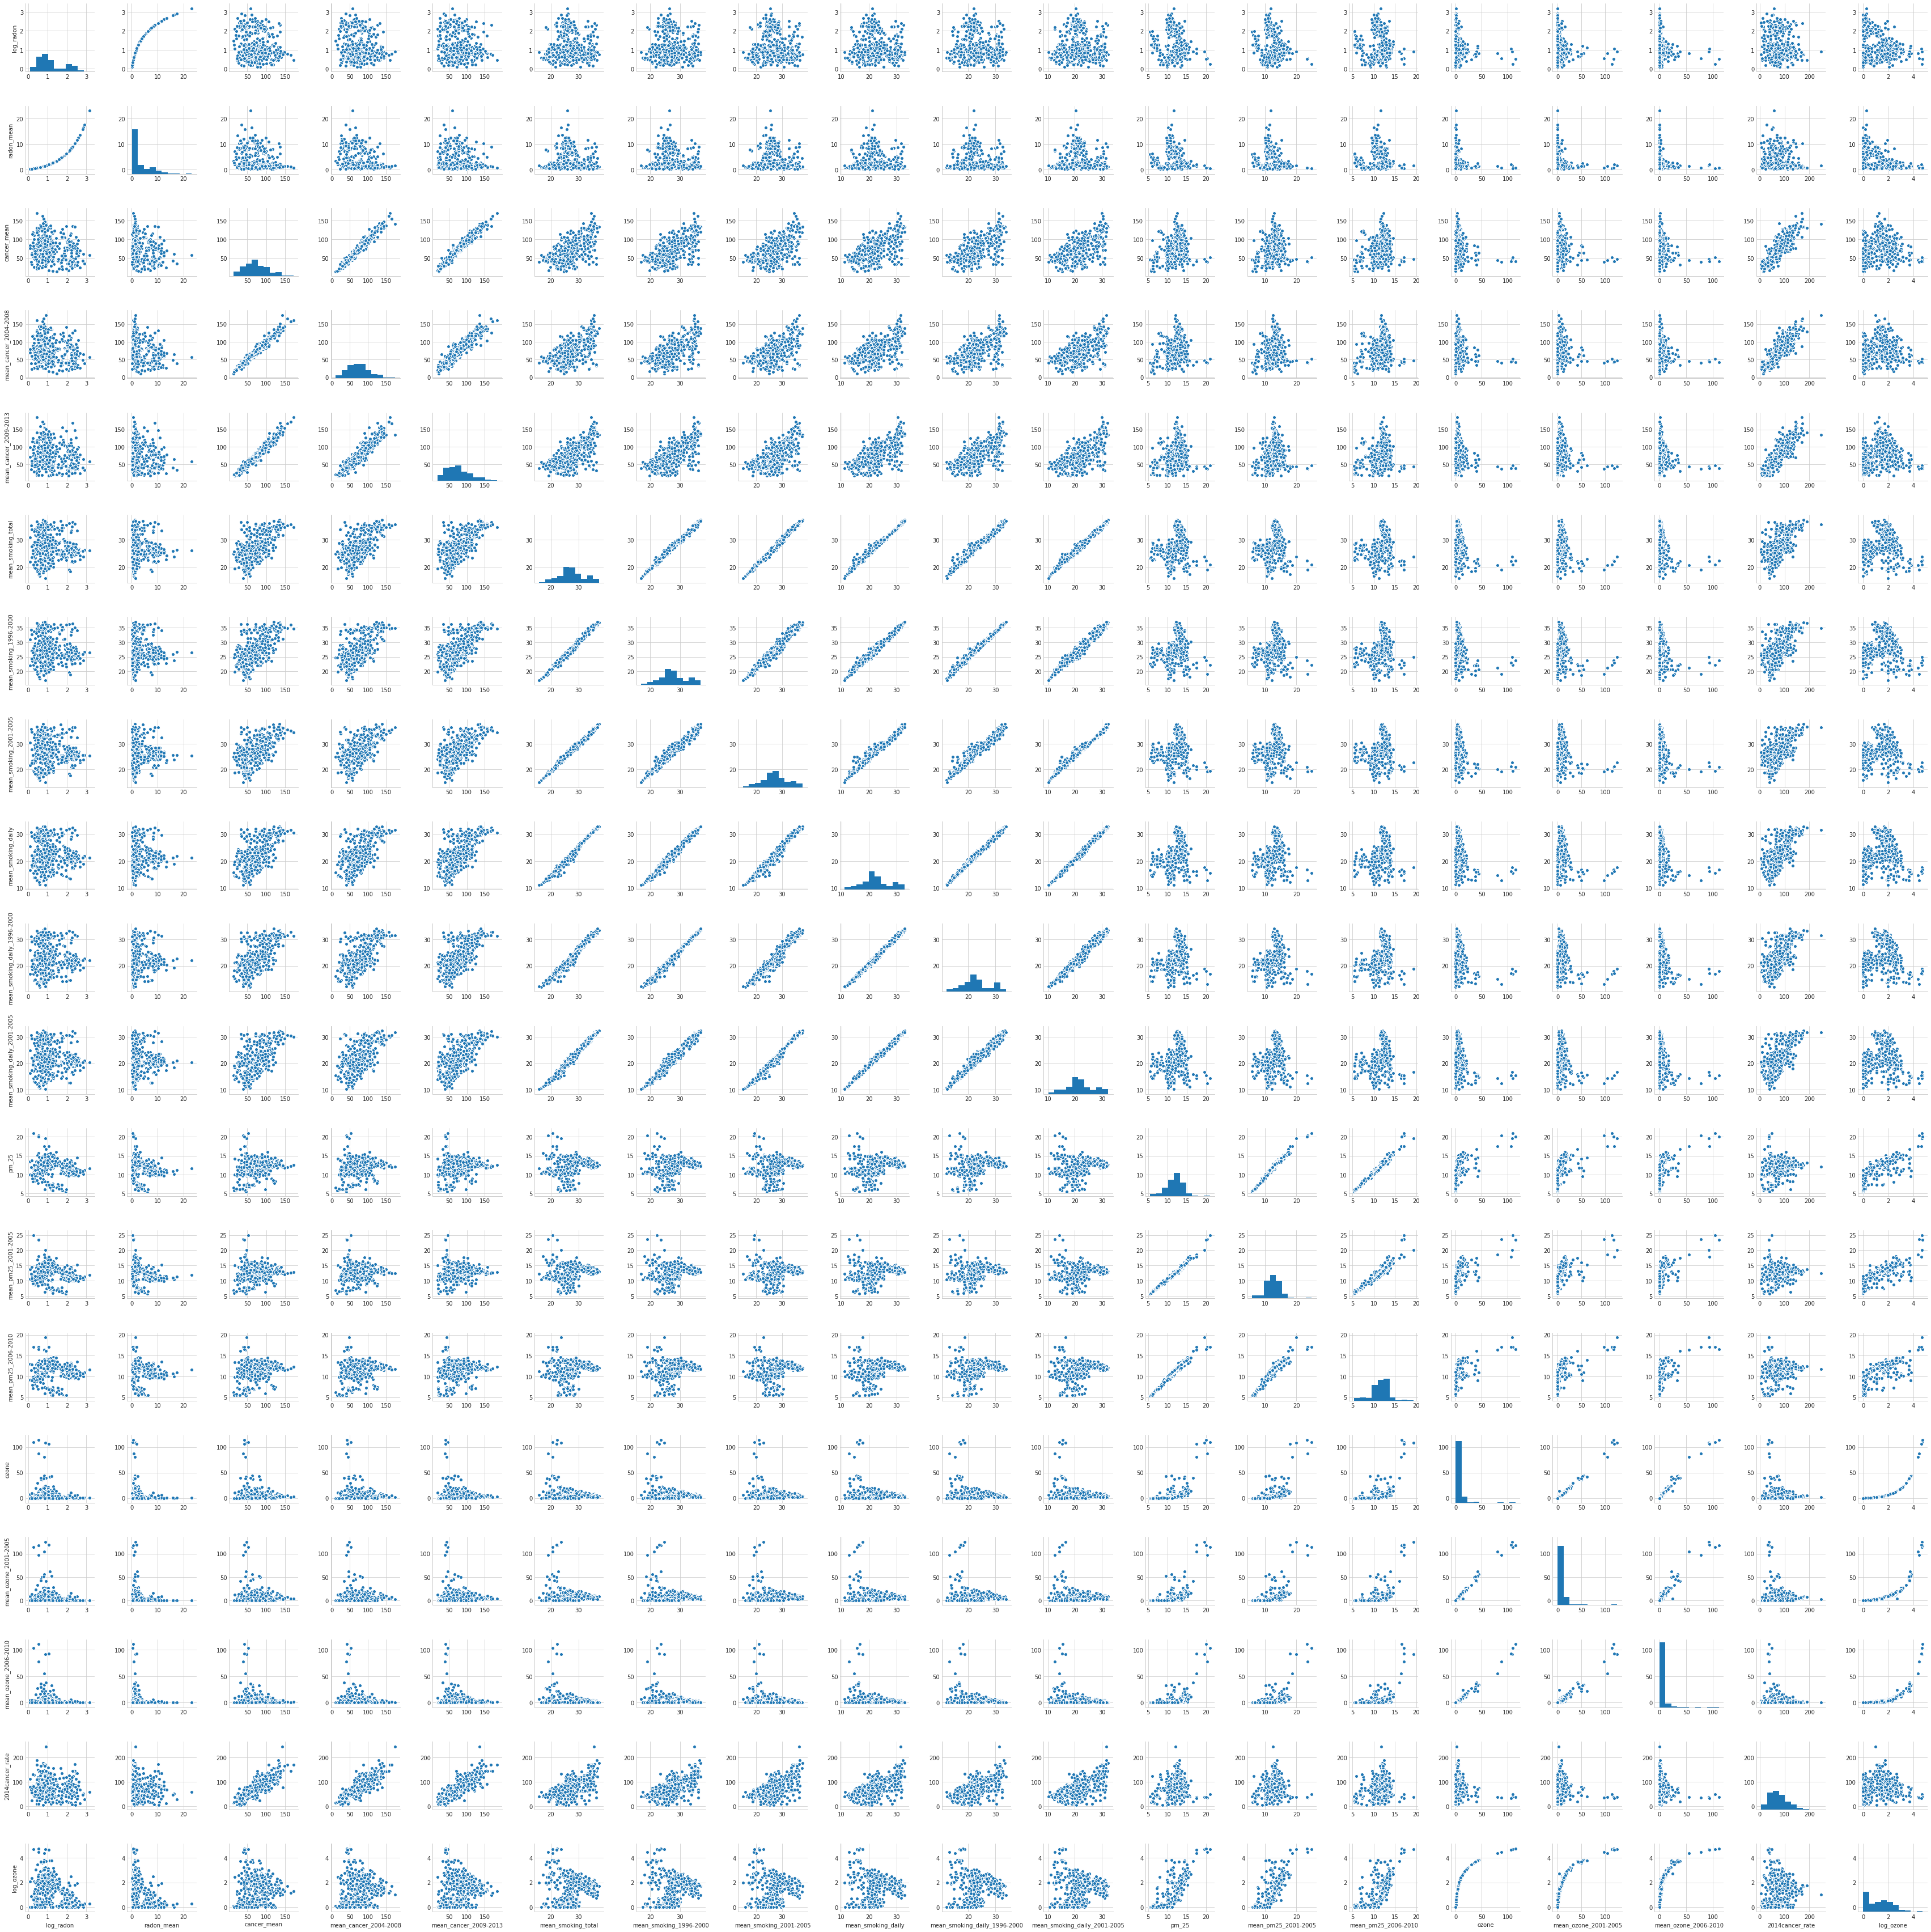

In [1682]:
sns.pairplot(data)

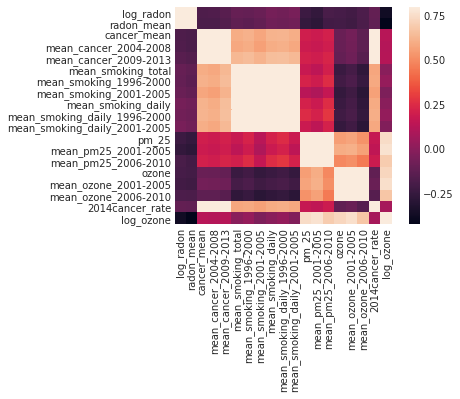

In [1683]:
sns.heatmap(data.corr(), vmax=.8, square=True)

In [1656]:
full_data = df.copy()
full_data = full_data[['log_radon','radon_mean']]
full_data = pd.concat([full_data, cr, sd,  s,  pm, oz], axis=1)
#, smoking_daily, pm_25, ozone
full_data.columns

Index(['log_radon', 'radon_mean', '2000cancer_rate', '2001cancer_rate',
       '2002cancer_rate', '2003cancer_rate', '2004cancer_rate',
       '2005cancer_rate', '2006cancer_rate', '2007cancer_rate',
       '2008cancer_rate', '2009cancer_rate', '2010cancer_rate',
       '2011cancer_rate', '2012cancer_rate', '2013cancer_rate',
       '2014cancer_rate', 'mean_cancer', 'mean_cancer_2004-2008',
       'mean_cancer_2009-2013', '1996smoking_daily', '1997smoking_daily',
       '1998smoking_daily', '1999smoking_daily', '2000smoking_daily',
       '2001smoking_daily', '2002smoking_daily', '2003smoking_daily',
       '2004smoking_daily', '2005smoking_daily', 'mean_smoking_daily',
       'mean_smoking_daily_1996-2000', 'mean_smoking_daily_2001-2005',
       '1996smoking_total', '1997smoking_total', '1998smoking_total',
       '1999smoking_total', '2000smoking_total', '2001smoking_total',
       '2002smoking_total', '2003smoking_total', '2004smoking_total',
       '2005smoking_total', 'mean_smokin

In [1657]:
def plot_top_correlation_matrix(data):
    corr = data.corr()
    corr = abs(corr['2014cancer_rate']).sort_values(ascending=False)
    corr = corr.head(15).index
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(12,8))
    cmap = sns.color_palette('coolwarm')
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5,
                yticklabels=True, annot=True, cbar_kws={'shrink':.5})
    plt.title('Top 15 Correlation Matrix')
    plt.xticks(rotation=90, fontsize=7)
    plt.yticks(rotation=0, fontsize=7)
    plt.tight_layout()
#plot_top_correlation_matrix(full_data)


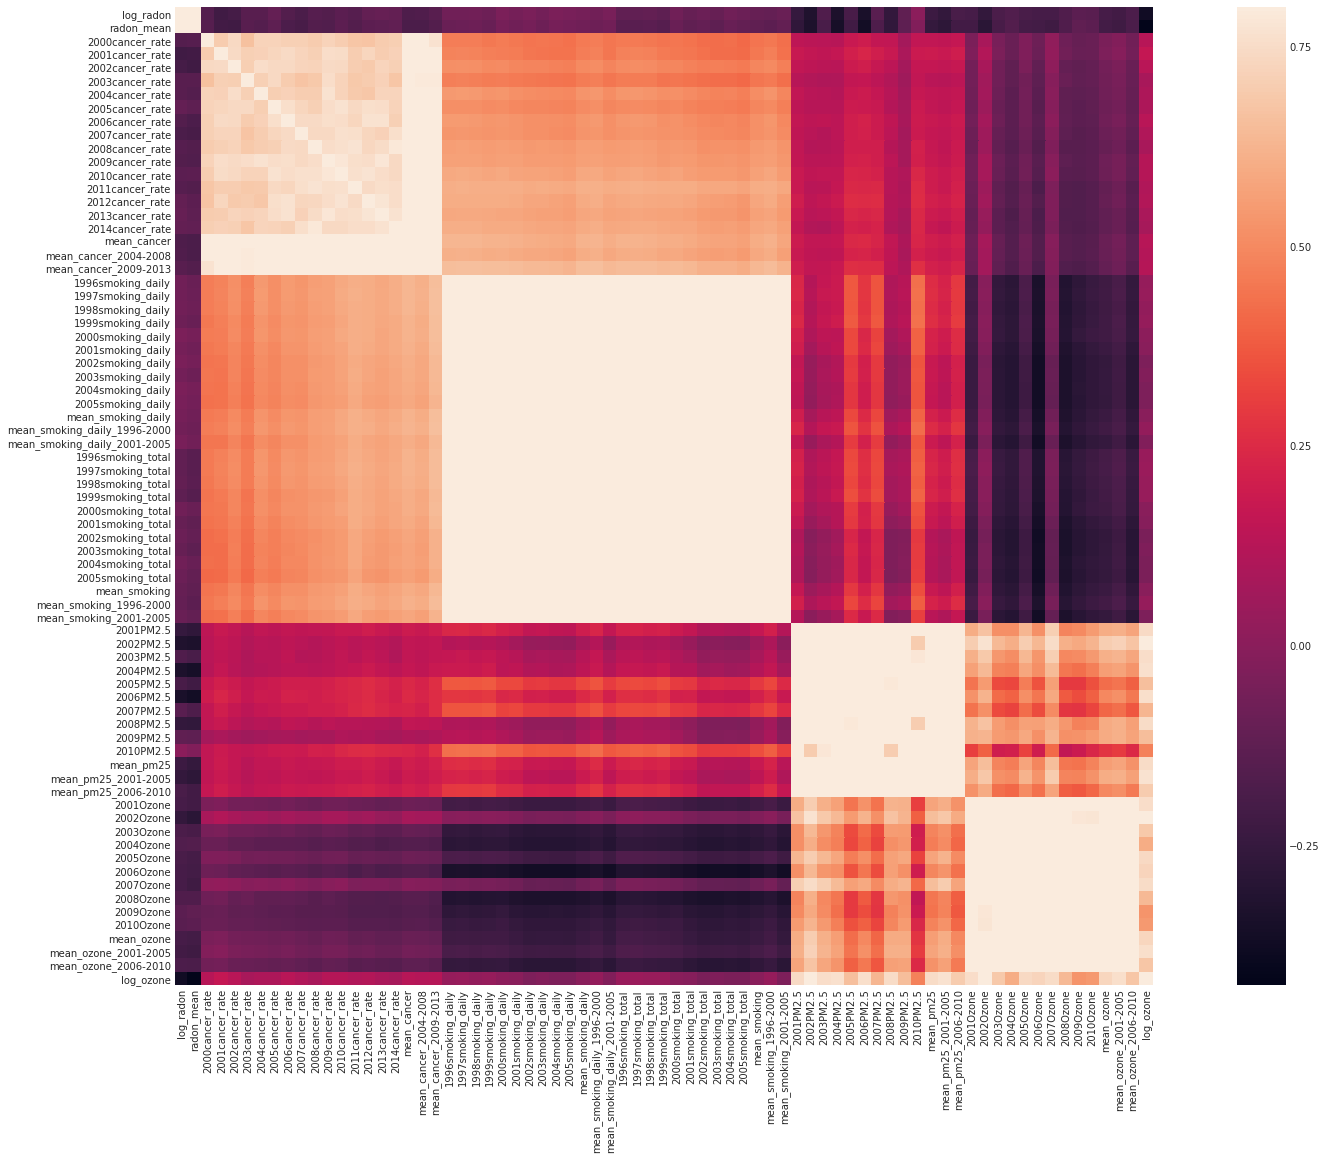

In [1658]:
f, ax = plt.subplots(figsize=(30, 18))
corrmat = full_data.corr()
sns.heatmap(corrmat, vmax=.8, square=True)

In [1659]:
#Looks like using smoking 1996-2000 could improve 

In [1660]:
# k = 10 #number of variables for heatmap
#cols = corrmat.nlargest(10, '2014cancer_rate')['2014cancer_rate'].index
# cm = np.corrcoef(full_data[cols].values.T)
# sns.set(font_scale=1.25)
# sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

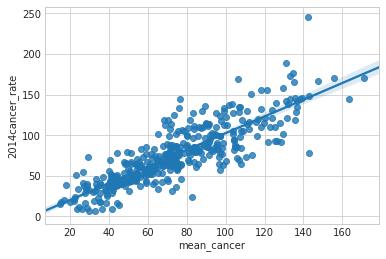

In [1661]:
sns.regplot(x="mean_cancer", y="2014cancer_rate", data=full_data)

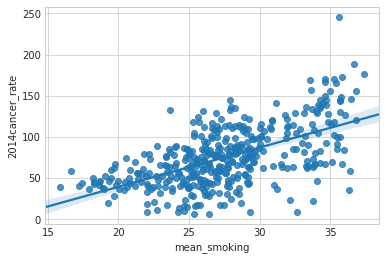

In [1662]:
sns.regplot(x="mean_smoking", y="2014cancer_rate", data=full_data)

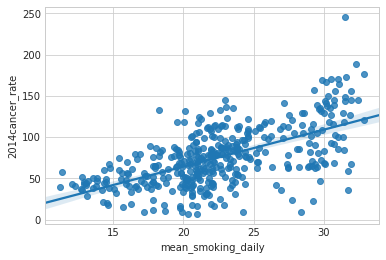

In [1663]:
sns.regplot(x="mean_smoking_daily", y="2014cancer_rate", data=full_data)

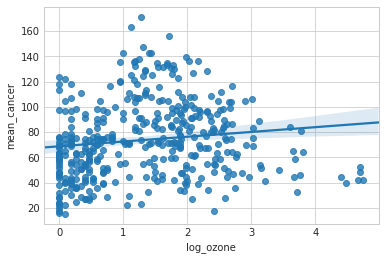

In [1664]:
sns.regplot(x="log_ozone", y="mean_cancer", data=full_data)

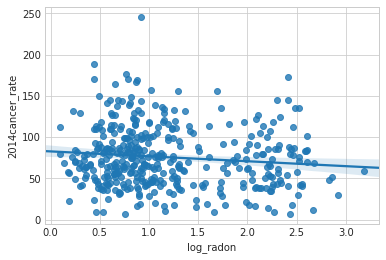

In [1665]:
sns.regplot(x="log_radon", y="2014cancer_rate", data=full_data)

In [1666]:
data.head()

log_radon  radon_mean  cancer_mean  \
State_and_county                                           
Alameda County, CA     0.586860    0.798333    47.767503   
Amador County, CA      0.891998    1.440000    99.087999   
Butte County, CA       0.396333    0.486364    83.502888   
Calaveras County, CA   0.783394    1.188889    88.767495   
Colusa County, CA      0.438255    0.550000    22.386951   

                      mean_cancer_2004-2008  mean_cancer_2009-2013  \
State_and_county                                                     
Alameda County, CA                47.320742              44.866175   
Amador County, CA                 91.758962             102.592423   
Butte County, CA                  83.969759              76.978697   
Calaveras County, CA              85.806105              90.730855   
Colusa County, CA                 24.235176              19.687481   

                      mean_smoking_total  mean_smoking_1996-2000  \
State_and_county                                                   
Alameda County, CA                 18.65                   19.78   
Amador County, CA                  23.66                   23.48   
Butte County, CA                   23.31                   23.68   
Calaveras County, CA               22.76                   22.96   
Colusa County, CA                  24.74                   25.14   

                      mean_smoking_2001-2005  mean_smoking_daily  \
State_and_county                                                   
Alameda County, CA                     17.52               13.04   
Amador County, CA                      23.84               18.26   
Butte County, CA                       22.94               18.20   
Calaveras County, CA                   22.56               17.63   
Colusa County, CA                      24.34               17.84   

                      mean_smoking_daily_1996-2000  \
State_and_county                                     
Alameda County, CA                           13.78   
Amador County, CA                            18.62   
Butte County, CA                             18.70   
Calaveras County, CA                         18.24   
Colusa County, CA                            18.50   

                      mean_smoking_daily_2001-2005      pm_25  \
State_and_county                                                
Alameda County, CA                           12.30  11.866575   
Amador County, CA                            17.90  11.293289   
Butte County, CA                             17.70  11.164623   
Calaveras County, CA                         17.02  11.017248   
Colusa County, CA                            17.18   9.653864   

                      mean_pm25_2001-2005  mean_pm25_2006-2010  ozone  \
State_and_county                                                        
Alameda County, CA              12.494306            11.238843    5.7   
Amador County, CA               12.089536            10.497042   13.4   
Butte County, CA                11.639545            10.689701   19.7   
Calaveras County, CA            11.841794            10.192702   21.7   
Colusa County, CA               10.392985             8.914742    1.9   

                      mean_ozone_2001-2005  mean_ozone_2006-2010  \
State_and_county                                                   
Alameda County, CA                     5.8                   5.6   
Amador County, CA                     15.8                  11.0   
Butte County, CA                      23.6                  15.8   
Calaveras County, CA                  28.2                  15.2   
Colusa County, CA                      3.2                   0.6   

                      2014cancer_rate  
State_and_county                       
Alameda County, CA          41.644187  
Amador County, CA          133.373255  
Butte County, CA            66.525579  
Calaveras County, CA        89.708224  
Colusa County, CA           23.522770

Looking at individual counties

In [1667]:
large_counties.sort_values(by='2014_pop', ascending=False)

2000cancer_rate  2001cancer_rate  2002cancer_rate  \
State_and_county                                                               
Los Angeles County, CA           41.821347        42.488942        40.851386   
San Diego County, CA             56.766616        52.793490        52.097071   
Orange County, CA                46.312628        47.028946        46.797983   
Riverside County, CA             62.155826        58.392932        57.256422   
San Bernardino County, CA        48.893010        46.628361        44.060671   
King County, WA                  57.849039        53.874089        56.576362   
Santa Clara County, CA           37.924042        38.209044        39.416587   
Wayne County, MI                 81.467781        85.602401        83.895724   
Alameda County, CA               55.799261        48.316280        51.706237   
Sacramento County, CA            65.206433        62.704490        57.644463   
Oakland County, MI               61.947975        66.559760        69.397584   
Contra Costa County, CA          54.470461        60.250146        53.476918   
Fulton County, GA                52.316250        49.377418        52.378242   
Fresno County, CA                45.801260        45.632278        43.988517   
Gwinnett County, GA              31.397754        43.385347        36.449393   
Kern County, CA                  53.931663        57.791165        51.292469   
Macomb County, MI                87.627680        89.935808        83.739766   
Ventura County, CA               50.230930        49.042050        45.029500   
San Francisco County, CA         62.605655        60.189661        62.506228   
Pierce County, WA                70.313199        70.486721        67.024589   
Snohomish County, WA             50.066893        62.179662        58.588245   
Jefferson County, KY            108.151077       105.571326       104.028236   
San Mateo County, CA             56.370264        61.222668        50.600033   
Cobb County, GA                  47.751040        44.622363        50.236285   
San Joaquin County, CA           60.927829        62.076396        65.348638   
Bernalillo County, NM            44.117568        42.712245        45.270687   

                           2003cancer_rate  2004cancer_rate  2005cancer_rate  \
State_and_county                                                               
Los Angeles County, CA           40.349560        40.895460        40.464429   
San Diego County, CA             51.085840        49.249029        53.192666   
Orange County, CA                43.114984        43.750049        44.216860   
Riverside County, CA             58.984363        56.502896        53.111501   
San Bernardino County, CA        44.525937        43.863691        44.291855   
King County, WA                  55.913442        54.357102        55.256374   
Santa Clara County, CA           42.738845        38.661181        41.842952   
Wayne County, MI                 90.072846        83.374079        90.498061   
Alameda County, CA               51.988670        47.381203        48.905861   
Sacramento County, CA            60.292157        56.118470        59.376139   
Oakland County, MI               71.145890        66.870907        67.317513   
Contra Costa County, CA          59.441172        52.195433        52.351671   
Fulton County, GA                49.349716        48.549626        45.557975   
Fresno County, CA                43.791674        46.571858        45.617614   
Gwinnett County, GA              32.861465        37.092636        34.600227   
Kern County, CA                  55.161059        52.967828        45.088508   
Macomb County, MI                87.624482        92.055311        90.616761   
Ventura County, CA               41.493776        46.725794        47.847071   
San Francisco County, CA         62.650099        58.319377        63.956719   
Pierce County, WA                69.076487        69.176382        71.242588   
Snohomish County, WA      

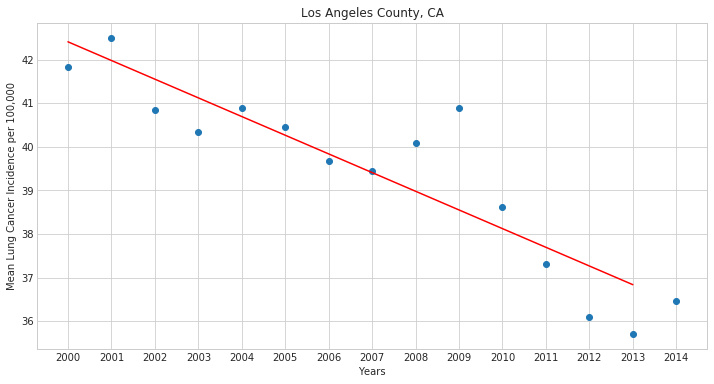

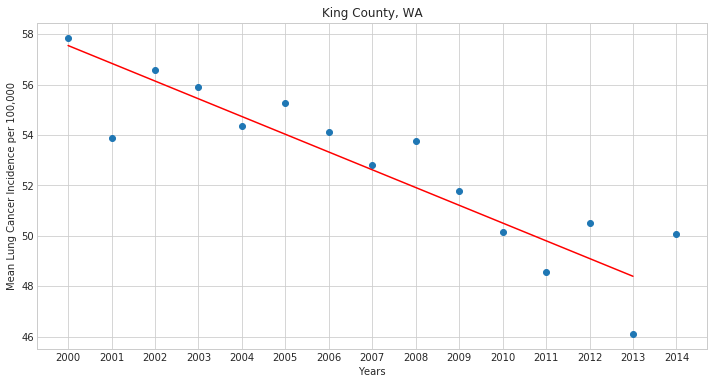

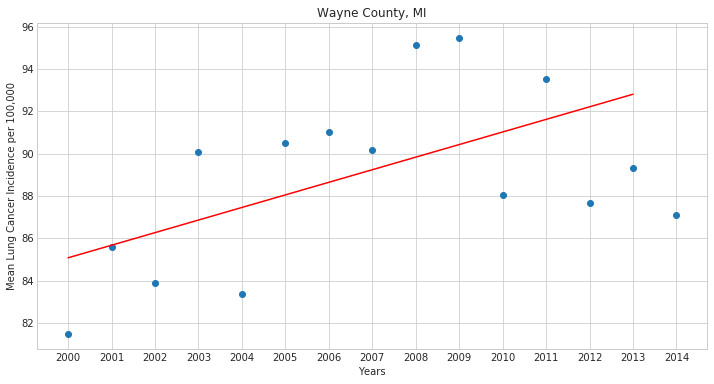

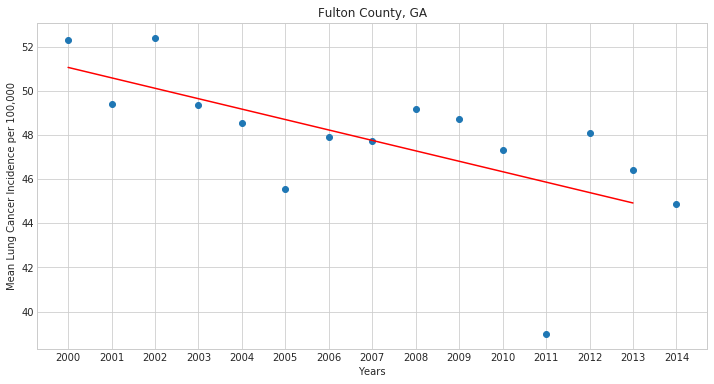

In [1668]:
counties = ['Los Angeles County, CA','King County, WA', 'Wayne County, MI', 'Fulton County, GA']
for county in counties:
    fig, ax = plt.subplots(figsize=(12,6))
    county_data = large_counties.loc[county][:15]
    ax.scatter([str(i) for i in county_data.index.str[:4]],county_data)
    X = np.array([int(i) for i in county_data.index.str[:4][:14]])
    Y = np.array(county_data[:14])
    fit = np.polyfit(X, Y, deg=1)
    ax.plot(X, fit[0] * X + fit[1], color='red')
    plt.xlabel('Years', fontsize=10)
    plt.ylabel('Mean Lung Cancer Incidence per 100,000', fontsize=10)
    plt.title(county)

In [1684]:
y = data.pop('2014cancer_rate')
X = data
X.columns

Index(['log_radon', 'radon_mean', 'cancer_mean', 'mean_cancer_2004-2008',
       'mean_cancer_2009-2013', 'mean_smoking_total', 'mean_smoking_1996-2000',
       'mean_smoking_2001-2005', 'mean_smoking_daily',
       'mean_smoking_daily_1996-2000', 'mean_smoking_daily_2001-2005', 'pm_25',
       'mean_pm25_2001-2005', 'mean_pm25_2006-2010', 'ozone',
       'mean_ozone_2001-2005', 'mean_ozone_2006-2010', 'log_ozone'],
      dtype='object')

Difference between large, medium and small counties?

In [1685]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


In [1686]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test) 

In [1687]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [1688]:
scores = cross_val_score(lm, X, y, cv=5)
print(scores.mean())

0.647312205828


In [1689]:
X.head()

log_radon  radon_mean  cancer_mean  \
State_and_county                                           
Alameda County, CA     0.586860    0.798333    47.767503   
Amador County, CA      0.891998    1.440000    99.087999   
Butte County, CA       0.396333    0.486364    83.502888   
Calaveras County, CA   0.783394    1.188889    88.767495   
Colusa County, CA      0.438255    0.550000    22.386951   

                      mean_cancer_2004-2008  mean_cancer_2009-2013  \
State_and_county                                                     
Alameda County, CA                47.320742              44.866175   
Amador County, CA                 91.758962             102.592423   
Butte County, CA                  83.969759              76.978697   
Calaveras County, CA              85.806105              90.730855   
Colusa County, CA                 24.235176              19.687481   

                      mean_smoking_total  mean_smoking_1996-2000  \
State_and_county                                                   
Alameda County, CA                 18.65                   19.78   
Amador County, CA                  23.66                   23.48   
Butte County, CA                   23.31                   23.68   
Calaveras County, CA               22.76                   22.96   
Colusa County, CA                  24.74                   25.14   

                      mean_smoking_2001-2005  mean_smoking_daily  \
State_and_county                                                   
Alameda County, CA                     17.52               13.04   
Amador County, CA                      23.84               18.26   
Butte County, CA                       22.94               18.20   
Calaveras County, CA                   22.56               17.63   
Colusa County, CA                      24.34               17.84   

                      mean_smoking_daily_1996-2000  \
State_and_county                                     
Alameda County, CA                           13.78   
Amador County, CA                            18.62   
Butte County, CA                             18.70   
Calaveras County, CA                         18.24   
Colusa County, CA                            18.50   

                      mean_smoking_daily_2001-2005      pm_25  \
State_and_county                                                
Alameda County, CA                           12.30  11.866575   
Amador County, CA                            17.90  11.293289   
Butte County, CA                             17.70  11.164623   
Calaveras County, CA                         17.02  11.017248   
Colusa County, CA                            17.18   9.653864   

                      mean_pm25_2001-2005  mean_pm25_2006-2010  ozone  \
State_and_county                                                        
Alameda County, CA              12.494306            11.238843    5.7   
Amador County, CA               12.089536            10.497042   13.4   
Butte County, CA                11.639545            10.689701   19.7   
Calaveras County, CA            11.841794            10.192702   21.7   
Colusa County, CA               10.392985             8.914742    1.9   

                      mean_ozone_2001-2005  mean_ozone_2006-2010  log_ozone  
State_and_county                                                             
Alameda County, CA                     5.8                   5.6   1.902108  
Amador County, CA                     15.8                  11.0   2.667228  
Butte County, CA                      23.6                  15.8   3.030134  
Calaveras County, CA                  28.2                  15.2   3.122365  
Colusa County, CA                      3.2                   0.6   1.064711

Lasso Regression

In [1690]:
lasso = Lasso(alpha=0.05)
lasso.fit(X_train, y_train)

Lasso(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [1691]:
cross_val_score(lasso, lasso.predict(X_test).reshape(-1,1),y_test.values.reshape(-1,1), cv=5).mean()

0.70912759112804158

In [1692]:
variables = np.array(list(zip(X.columns,lasso.coef_)))
# for i in variables:
# #     if i[1]=='0.0' or i[1]=='-0.0':
# #         variables.remove(i)
#print(np.sort(variables, axis=0))
print(variables)

[['log_radon' '0.866661102254']
 ['radon_mean' '0.0']
 ['cancer_mean' '16.2630341024']
 ['mean_cancer_2004-2008' '11.208594238']
 ['mean_cancer_2009-2013' '2.17597841904']
 ['mean_smoking_total' '3.5700543462']
 ['mean_smoking_1996-2000' '0.0']
 ['mean_smoking_2001-2005' '0.104197053346']
 ['mean_smoking_daily' '0.0573222591144']
 ['mean_smoking_daily_1996-2000' '0.318285638511']
 ['mean_smoking_daily_2001-2005' '0.0']
 ['pm_25' '-0.0']
 ['mean_pm25_2001-2005' '-2.84749092113']
 ['mean_pm25_2006-2010' '3.87034695382']
 ['ozone' '0.0']
 ['mean_ozone_2001-2005' '-0.0']
 ['mean_ozone_2006-2010' '0.452198479408']
 ['log_ozone' '-1.76674481124']]


In [1717]:
regr = ElasticNet(alpha=0.3, l1_ratio=0.7, random_state=0)
regr.fit(X_train, y_train)

ElasticNet(alpha=0.3, copy_X=True, fit_intercept=True, l1_ratio=0.7,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False)

In [1718]:
cross_val_score(regr, regr.predict(X_test).reshape(-1,1),y_test.values.reshape(-1,1), cv=5).mean()

0.72012192116679141